In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


if tf.test.is_gpu_available():
  device_name = tf.test.gpu_device_name()
else:
  device_name = '/CPU:0'

##Loading mnist

In [ ]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

##Functions to create generator and discriminator net

In [ ]:
## define a function for the generator:
def make_generator_network(num_hidden_layers=1, num_hidden_units=100, num_output_units=784):
  model = tf.keras.Sequential()

  for i in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(units=num_hidden_units, use_bias=False))
    model.add(tf.keras.layers.LeakyReLU()) #for sparse gradients
    model.add(tf.keras.layers.Dense(units=num_output_units, activation='tanh'))

  return model


## define a function for the discriminator:
def make_discriminator_network(num_hidden_layers=1, num_hidden_units=100, num_output_units=1):
  model = tf.keras.Sequential()

  for i in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(units=num_hidden_units))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(units=num_output_units, activation=None))#linear activation, sigmoid for propabilities

  return model

In [ ]:
def preprocess(ex, mode='uniform'):
  image = ex['image']
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.reshape(image, [-1])
  image = image*2 - 1.0

  if mode == 'uniform':
    input_z = tf.random.uniform(shape=(z_size,), minval=-1.0, maxval=1.0)
  elif mode == 'normal':
    input_z = tf.random.normal(shape=(z_size,))

  return input_z, image

##Train GAN

In [ ]:
import time
num_epochs = 1000
batch_size = 1
image_size = (28, 28)
z_size = 20
filter_value = 8
take_value = 5
mode_z = 'uniform'


gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)

if mode_z == 'uniform':
  fixed_z = tf.random.uniform(shape=(batch_size,z_size), minval=-1, maxval=1)
elif mode_z == 'normal':
  fixed_z = tf.random.normal(shape=(batch_size, z_size))

## Set-up the dataset
mnist_trainset = mnist['train'].filter(lambda f: (f['label']==filter_value)).take(take_value)
realds = mnist_trainset #keep copy of dataset
mnist_trainset = mnist_trainset.map(lambda ex: preprocess(ex, mode=mode_z))
mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(batch_size, drop_remainder=True)

## Set-up the model
with tf.device(device_name):
  gen_model = make_generator_network(num_hidden_layers=gen_hidden_layers, num_hidden_units=gen_hidden_size, num_output_units=np.prod(image_size))
  gen_model.build(input_shape=(None, z_size))

  disc_model = make_discriminator_network(num_hidden_layers=disc_hidden_layers, num_hidden_units=disc_hidden_size)
  disc_model.build(input_shape=(None, np.prod(image_size)))

def create_samples(g_model, input_z):
  g_output = g_model(input_z, training=False)
  images = tf.reshape(g_output, (batch_size, *image_size))

  return (images+1)/2.0
  
def rate_samples(d_model, image):
  image = (image*2)-1
  image = tf.reshape(image, [batch_size,-1])
  d_output = d_model(image, training = False)

  return d_output

## Loss function and optimizers:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()
all_losses = []
all_d_vals = []
epoch_samples = []
epoch_samples2 = []
start_time = time.time()

for epoch in range(1, num_epochs+1):
  epoch_losses, epoch_d_vals = [], []

  for i,(input_z,input_real) in enumerate(mnist_trainset):
  ## Compute generator's loss

    with tf.GradientTape() as g_tape:
      g_output = gen_model(input_z)
      d_logits_fake = disc_model(g_output, training=True)
      labels_real = tf.ones_like(d_logits_fake)
      g_loss = loss_fn(y_true=labels_real,y_pred=d_logits_fake)

    ## Compute the gradients of g_loss
    g_grads = g_tape.gradient(g_loss,gen_model.trainable_variables)

    ## Optimization: Apply the gradients
    g_optimizer.apply_gradients(grads_and_vars=zip(g_grads, gen_model.trainable_variables))

    ## Compute discriminator's loss
    with tf.GradientTape() as d_tape:
     d_logits_real = disc_model(input_real, training=True)
     d_labels_real = tf.ones_like(d_logits_real)
     d_loss_real = loss_fn(y_true=d_labels_real, y_pred=d_logits_real)
     d_logits_fake = disc_model(g_output, training=True)
     d_labels_fake = tf.zeros_like(d_logits_fake)
     d_loss_fake = loss_fn(y_true=d_labels_fake, y_pred=d_logits_fake)
     d_loss = d_loss_real + d_loss_fake

    ## Compute the gradients of d_loss
    d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)

    ## Optimization: Apply the gradients
    d_optimizer.apply_gradients(grads_and_vars=zip(d_grads, disc_model.trainable_variables))
    epoch_losses.append((g_loss.numpy(), d_loss.numpy(), d_loss_real.numpy(), d_loss_fake.numpy()))
    d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
    d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
    epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))

  all_losses.append(epoch_losses)
  all_d_vals.append(epoch_d_vals)

  a=epoch%100
  if a==0:
    print('Epoch {:03d} | ET {:.2f} min | Avg Losses >>'' G/D {:.4f}/{:.4f} [D-Real: {:.4f} D-Fake: {:.4f}]'
    .format(epoch, (time.time() - start_time)/60,*list(np.mean(all_losses[-1], axis=0))))

  epoch_samples.append(create_samples(gen_model, fixed_z).numpy())


Epoch 100 | ET 0.17 min | Avg Losses >> G/D 5.0132/0.6485 [D-Real: 0.1044 D-Fake: 0.5442]
Epoch 200 | ET 0.33 min | Avg Losses >> G/D 2.0975/0.0535 [D-Real: 0.0276 D-Fake: 0.0259]
Epoch 300 | ET 0.50 min | Avg Losses >> G/D 1.6443/0.9883 [D-Real: 0.8498 D-Fake: 0.1386]
Epoch 400 | ET 0.68 min | Avg Losses >> G/D 2.1145/2.5088 [D-Real: 0.1081 D-Fake: 2.4007]
Epoch 500 | ET 0.85 min | Avg Losses >> G/D 0.4808/1.4117 [D-Real: 0.0713 D-Fake: 1.3404]
Epoch 600 | ET 1.02 min | Avg Losses >> G/D 3.7377/2.8357 [D-Real: 1.8903 D-Fake: 0.9454]
Epoch 700 | ET 1.18 min | Avg Losses >> G/D 6.2714/0.6733 [D-Real: 0.4299 D-Fake: 0.2434]
Epoch 800 | ET 1.34 min | Avg Losses >> G/D 1.7222/0.0532 [D-Real: 0.0237 D-Fake: 0.0295]
Epoch 900 | ET 1.51 min | Avg Losses >> G/D 4.4920/0.0592 [D-Real: 0.0341 D-Fake: 0.0251]
Epoch 1000 | ET 1.68 min | Avg Losses >> G/D 0.4598/0.8971 [D-Real: 0.0652 D-Fake: 0.8319]


#Visualization

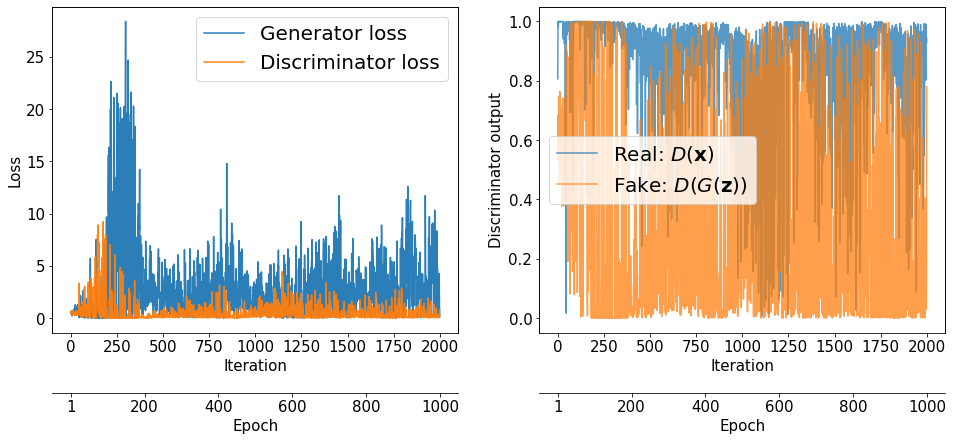

In [ ]:
import itertools
fig = plt.figure(figsize=(16, 6))
## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain( *all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)
epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 200, 400, 600, 800, 1000]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain( *all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.show()

##Showing created samples

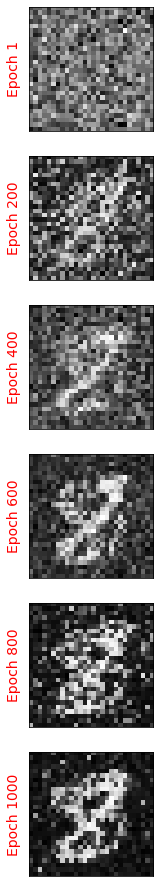

In [ ]:
selected_epochs = [1, 200, 400, 600, 800, 1000]
fig = plt.figure(figsize=(10, 16))

for i,e in enumerate(selected_epochs):
  for j in range(1):
    ax = fig.add_subplot(6, 1, i*1+j+1)
    ax.set_xticks([])
    ax.set_yticks([])

    if j == 0:
      ax.text(-0.06, 0.5, 'Epoch {}'.format(e), rotation=90, size=14, color='red', horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)

    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray')
    
plt.show()

#Saving all Images

##Save drawn images

In [ ]:
n=100
unedited_samples = []
samples = []
samples_rating = []

##invert pictures if colors are inverted
def invertWhite(image):
  a = 0
  for i in range(2):
    for j in range(2):
      a += image[i][j]+image[len(image)-1-i][len(image)-1-j]
      a += image[len(image)-1-i][j]+image[i][len(image)-1-j]

  a = a/16
  if a>0.5:
    for i in range(len(image)):
      for j in range(len(image[0])):
        image[i][j]=1-image[i][j]

  return image

def elemntForIf(list1, N):
  list2=[]
  for i in range(len(list1)):
    for j in range(len(list1[0])):
      list2.append(list1[i][j])
  list2.sort(reverse=True)

  return list2[N-1]

for i in range(1000):
  tf.random.set_seed(i)
  input = tf.random.uniform(shape=(batch_size, z_size), minval=-1, maxval=1)
  unedited_samples.append(create_samples(gen_model, input).numpy())

for i in range(len(unedited_samples)):
  for j in range(len(unedited_samples[0])):
    unedited_samples[i][j] = invertWhite(unedited_samples[i][j])
  unedited_samples[i] = tf.convert_to_tensor(unedited_samples[i])

for i in range(len(unedited_samples)):
  samples_rating.append(rate_samples(disc_model, unedited_samples[i]).numpy())
  samples.append(unedited_samples[i].numpy())

f = elemntForIf(samples_rating, n)

In [ ]:
path = "/path/to/datasets/"
%cd $path

c=0
for i in range(len(samples)):
  for j in range(len(samples[0])):
    if samples_rating[i][j]>=f:
      matplotlib.image.imsave(str(filter_value)+"("+"{}".format(c)+")"+".jpg", samples[i][j], cmap="gray")
      c+=1

/content/drive/MyDrive/Colab Notebooks/test
